In [2]:
import networkExpansionPy.lib as ne
import numpy as np
import pandas as pd
import pickle as pickle
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr,pearsonr,mannwhitneyu
from statsmodels.stats.multitest import multipletests
plt.rcParams['font.family'] = 'Arial'
import pingouin as pg

import warnings
from scipy.sparse import (spdiags, SparseEfficiencyWarning, csc_matrix,
    csr_matrix, isspmatrix, dok_matrix, lil_matrix, bsr_matrix)
warnings.simplefilter('ignore',SparseEfficiencyWarning)

def load_data(network_name):
    with open(ne.asset_path  + "/metabolic_networks/" + network_name,"rb") as filehandler:
        metabolism = pickle.load(filehandler)
    return metabolism

# load the metabolism object from the repo
model_id = "metabolism.v8.01May2023.pkl"
metabolism = pd.read_pickle('/Users/joshuagoldford/Documents/github/network-expansion-assets/models/' + model_id)
cids = metabolism.coenzymes

In [10]:
seed = pd.read_csv('../assets/seed_set.csv')
#background = seed[seed["Type"].isin(["Background"])].ID.tolist()
#cpd_base = seed[~seed["Type"].isin(['Sulfur source',"Nitrogen source"])].ID.tolist()
carbon_compounds = sedd[~seed["Type"].isin(["Organic carbon"])].ID.tolist()

In [19]:
#load dor


import re
def get_c_num(formula):
    match = re.search('C(\d+)', formula)
    if match:
        return  match.group(1)
    else:
        return None


DOR = pd.read_csv("../assets/keggCHOmolecules.reductionState.csv",index_col=0)
    
DOR["c"]= DOR.formula.apply(lambda x: get_c_num(x))
DOR = DOR[~DOR.c.apply(lambda x: x is None)]
DOR["c"] = DOR.c.apply(int)

complexity = pd.read_csv("../assets/kegg_compound_complexity_metrics.csv",index_col=0)
cpd_features = DOR.set_index("cid").join(complexity.set_index("cid"))

In [62]:
cx  = cpd_features[cpd_features["c"] < 1e9]

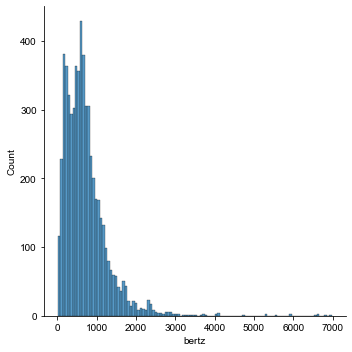

In [63]:
sns.displot(x="bertz",data=cx)

In [64]:
len(cx)

5977

In [65]:
cx = cx.sort_values("bertz")
r_upper = cx.bertz.quantile(q=0.75)
r_lower = cx.bertz.quantile(q=0.25)

In [66]:
cpd_complex = cx[cx.bertz > r_upper].index.tolist()
cpd_simple = cx[cx.bertz < r_lower].index.tolist()

In [67]:
# make seed sets
base_set = seed[~seed["Type"].isin(["Organic carbon"])].ID.tolist()

In [73]:
from random import sample
N = 10
samples = 5000
sample_types = []
seed_sets = []
for n in range(samples):
    seed_sets.append(sample(cpd_simple,N))
    sample_types.append("simple")
    
for n in range(samples):
    seed_sets.append(sample(cpd_complex,N))
    sample_types.append("complex")
    
seed_sets_full = [x + base_set for x in seed_sets]

In [74]:
compounds,reactions = metabolism.run_expansions_parallel(seed_sets_full,algorithm="naive")

In [75]:
g = pd.DataFrame({"stype":sample_types,"scope_size": [len(x) for x in compounds]})

In [81]:
g["expanded"] = g.scope_size > 4e3

In [83]:
g[["stype","expanded"]]

,stype,expanded
0,simple,True
1,simple,False
2,simple,False
3,simple,False
4,simple,False
...,...,...
9995,complex,False
9996,complex,False
9997,complex,False
9998,complex,False


In [91]:
x = pd.crosstab(g["stype"],g["expanded"])
x

expanded,False,True
stype,,
complex,5000,0
simple,4773,227


In [90]:
from scipy.stats import fisher_exact

In [93]:
fisher_exact(x.values)

(inf, 6.718821479528746e-70)

In [95]:
x.loc["simple"][True] / x.loc["simple"].sum()

0.0454

In [96]:
x.loc["complex"][True] / x.loc["complex"].sum()

0.0

In [97]:
g.to_csv("data/10RandomCompoundAddditions.ComplexityDistribution.06May2023.csv")

In [6]:
g = pd.read_csv("data/10RandomCompoundAddditions.ComplexityDistribution.06May2023.csv")

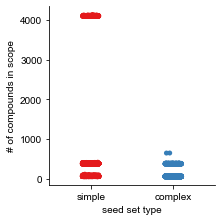

In [7]:
# make a plot showing the sizes of scopes with each seed set type4
z= sns.catplot(x="stype",y="scope_size",data=g,palette="Set1",height=3, aspect=1)

# Rasterize the points
for ax in z.axes.flatten():
    for c in ax.collections:  # the points are stored as collections
        c.set_rasterized(True)
        
plt.ylabel("# of compounds in scope")
plt.xlabel("seed set type")
plt.savefig("figs/randomSeedSets.Complexity.svg")